In [33]:
# Standard modules
import time
import matplotlib.pyplot as plt
import sympy as sym
import numpy as np
import control
from IPython.display import display, Markdown
import ae353_spacecraft_design as design
# My own script (an interface to the simulator)
import ae353_spacecraft_simulate

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

In [34]:
simulator = ae353_spacecraft_simulate.Simulator(
    # dt=0.01, #supposed to be 0.04
    display=False,
    seed=None,
)
simulator.camera_sideview()

argv[0]=


In [35]:
def set_iterate(simulator, controller, num_simulations=100):
    success_count = 0
    all_data = np.array([])
    all_docked = np.array([])
    for _ in range(num_simulations):
        simulator.reset(
            initial_conditions=None,
            scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
            space_debris=True,      # <-- whether or not there is space debris
            docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
        )
        controller.reset()
        data = simulator.run(
            controller,           # <-- required (an instance of your Controller class)
            max_time=65.0,         # <-- optional (how long you want to run the simulation in seconds)
            data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
            video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
            print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
        )
        has_docked = simulator.has_docked()
        if has_docked:
            success_count += 1
        all_data = np.append(all_data, data)
        all_docked = np.append(all_docked, has_docked)
    return (success_count / num_simulations, all_data, all_docked)

In [36]:
def iterate(delta=0.6, num_simulations=100):
    wheels = [
        {"alpha": 0 * np.pi / 4 + np.pi / 3, "delta": np.arctan(delta/np.sqrt(3))},
        {"alpha": 2 * np.pi / 3 + np.pi / 3, "delta": np.arctan(delta/np.sqrt(3))},
        {"alpha": 4 * np.pi / 3 + np.pi / 3, "delta": np.arctan(delta/np.sqrt(3))},
        {"alpha": 0 * np.pi / 4, "delta": -np.pi / 2},
    ]

    m, J = design.create_spacecraft(wheels)
    r = 0.20 # Adjust the radius as needed
    num_stars = 8

    # Generate star positions circularly
    stars = []
    for i in range(num_stars):
        theta = 2 * np.pi * i / num_stars  # Angle for each star
        alpha = r * np.cos(theta)          # x-coordinate (alpha)
        delta = r * np.sin(theta)          # y-coordinate (delta)
        stars.append({'alpha': alpha, 'delta': delta})

    design.create_stars(stars)

    # Define yaw, pitch, roll angles
    psi, theta, phi = sym.symbols('psi, theta, phi')

    # Define angular velocities
    w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

    # Define torques
    tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

    # Compute resultant torques
    T1 = - tau_1 * sym.Matrix(wheels[0]['xyz']) / np.linalg.norm(wheels[0]['xyz'])
    T2 = - tau_2 * sym.Matrix(wheels[1]['xyz']) / np.linalg.norm(wheels[1]['xyz'])
    T3 = - tau_3 * sym.Matrix(wheels[2]['xyz']) / np.linalg.norm(wheels[2]['xyz'])
    T4 = - tau_4 * sym.Matrix(wheels[3]['xyz']) / np.linalg.norm(wheels[3]['xyz'])
    T = sym.nsimplify(T1 + T2 + T3 + T4)

    # Define rotation matrices
    Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
    Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
    Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

    # Define the transformation from angular velocity to angular rates
    ex = sym.Matrix([[1], [0], [0]])
    ey = sym.Matrix([[0], [1], [0]])
    ez = sym.Matrix([[0], [0], [1]])
    M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

    # Define euler's equations
    Jx, Jy, Jz = [sym.nsimplify(j) for j in np.diag(J)]
    euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                        [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                        [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

    # Define equations of motion
    f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

    #picking all eq points as zero satisfies reuquiremend of the dot terms to be zero too
    psi_e = 0.
    theta_e = 0.
    phi_e = 0.
    w_xe = 0.
    w_ye = 0.
    w_ze = 0.
    tau_1e = 0.
    tau_2e = 0.
    tau_3e = 0.
    tau_4e = 0.

    m = sym.Matrix([psi,
                    theta,
                    phi,
                    w_x,
                    w_y,
                    w_z
    ])

    n = sym.Matrix([tau_1,
                    tau_2,
                    tau_3,
                    tau_4
    ])

    # A_num = sym.lambdify([psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4],f.jacobian(m))
    # A = A_num(0,0,0,0,0,0,0,0,0,0)
    A = f.jacobian(m).subs([(psi,psi_e),(theta,theta_e),(phi,phi_e),(w_x,w_xe),(w_y,w_ye),(w_z,w_ze),
                            (tau_1,tau_1e),(tau_2,tau_2e),(tau_3,tau_3e),(tau_4,tau_4e)])
    A = np.array(A).astype(float)
    # B_num = sym.lambdify([psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4],f.jacobian(n))
    # B = B_num(0,0,0,0,0,0,0,0,0,0)
    B = f.jacobian(n).subs([(psi,psi_e),(theta,theta_e),(phi,phi_e),(w_x,w_xe),(w_y,w_ye),(w_z,w_ze),
                            (tau_1,tau_1e),(tau_2,tau_2e),(tau_3,tau_3e),(tau_4,tau_4e)])
    B = np.array(B).astype(float)

    # W = B
    # shape= A.shape[0]
    # for i in range(1,shape):
    #     col= np.linalg.matrix_power(A,i)@B
    #     W = np.block([[W,col]])
    # W = W.astype(np.float64)
    # rank = np.linalg.matrix_rank(W)
    # print(shape)
    # print(rank)

    #finding K, but cant find u from here because of the sensor

    m_e = sym.Matrix([psi_e,
                    theta_e,
                    phi_e,
                    w_xe,
                    w_ye,
                    w_ze
    ])

    n_e = sym.Matrix([tau_1e,
                    tau_2e,
                    tau_3e,
                    tau_4e
    ])

    x = m - m_e
    u = n - n_e

    alpha, delta = sym.symbols('alpha, delta')
    # Position of star in space frame
    p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                                [sym.sin(alpha) * sym.cos(delta)],
                                [sym.sin(delta)]])

    # Orientation of body frame in space frame
    R_body_in_space = Rz * Ry * Rx

    # Position of star in body frame (assuming origin of body and space frames are the same)
    p_star_in_body = R_body_in_space.T * p_star_in_space

    # Position of star in image frame
    r = sym.nsimplify(design.scope_radius)
    p_star_in_image = (1 / r) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                            [p_star_in_body[2] / p_star_in_body[0]]])

    # Sensor model for each star
    g = sym.simplify(p_star_in_image, full=True)

    # Create an empty list to store the sensor models for all stars
    sensor_models = []

    # Loop over each star in the stars list
    for star in stars:
        alpha_val = star['alpha']
        delta_val = star['delta']
        
        # Position of star in space frame
        p_star_in_space = sym.Matrix([
            [sym.cos(alpha) * sym.cos(delta)],
            [sym.sin(alpha) * sym.cos(delta)],
            [sym.sin(delta)]
        ])
        
        # Orientation of body frame in space frame
        R_body_in_space = Rz * Ry * Rx
        
        # Position of star in body frame
        p_star_in_body = R_body_in_space.T * p_star_in_space
        
        # Position of star in image frame
        r = sym.nsimplify(design.scope_radius)  # Assuming design.scope_radius is defined
        p_star_in_image = (1 / r) * sym.Matrix([
            [p_star_in_body[1] / p_star_in_body[0]],
            [p_star_in_body[2] / p_star_in_body[0]]
        ])
        
        # Sensor model for current star
        g = sym.simplify(p_star_in_image, full=True)
        
        # Substitute the star's alpha and delta values
        g_substituted = g.subs({alpha: alpha_val, delta: delta_val})
        
        # Store the model
        sensor_models.append(g_substituted)

    # sensor_models now contains the sensor models for all stars
    # Stack all individual star sensor models into one vector
        g_total = sym.Matrix.vstack(*sensor_models)
        
    g_total.subs([])  # sensor_models contains all individual g's

    g_e = g_total.subs([(phi,phi_e),(theta,theta_e),(psi,psi_e)])
    g_e = np.array(g_e).flatten()
    g_e = g_e.astype(float)

    C = g_total.jacobian(x).subs([(psi,psi_e),(theta,theta_e),(phi,phi_e)])
    C = np.array(C).astype(float)

    Q_o = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])* 1e-1
    R_o = np.diag([1, 1, 1, 1, 1, 1]) * 1e-1
    Q = np.diag([500, 500, 500, 1, 1, 1])
    R = np.diag([1,1,1,1]) * 1e-2
    K, _, _ = control.lqr(A, B, Q, R)

    Lt, _, _ = (control.lqr(A.T, C.T, np.linalg.inv(R_o), np.linalg.inv(Q_o)))
    L = Lt.T

    m_e = sym.Matrix([psi_e,
                    theta_e,
                    phi_e,
                    w_xe,
                    w_ye,
                    w_ze
    ])

    n_e = sym.Matrix([tau_1e,
                    tau_2e,
                    tau_3e,
                    tau_4e
    ])
    

    class Controller:
        def __init__(self,K,L,A,B,C,psi_e,theta_e,phi_e,w_xe,w_ye,w_ze,tau_1e,tau_2e,tau_3e,tau_4e,g_e):
            # FIXME: add class variable names to this list (e.g., 'xhat')
            # if you want these variables to be logged by the simulator
            # self.variables_to_log = []
            self.K = K
            self.L = L
            self.A = A
            self.B = B
            self.C = C
            self.psi_e = psi_e
            self.theta_e  = theta_e
            self.phi_e = phi_e
            self.w_xe = w_xe
            self.w_ye = w_ye
            self.w_ze = w_ze
            self.tau_1e = tau_1e
            self.tau_2e = tau_2e
            self.tau_3e = tau_3e
            self.tau_3e = tau_3e
            self.tau_4e = tau_4e
            self.x = x
            self.n_e = n_e
            self.dt = 0.04
            self.g_e =  g_e
        def reset(self):
            self.xhat = np.array([0.,
                                0.,
                                0.,
                                0.,
                                0.,
                                0.])
        
        def run(self, t, star_measurements):
            """
            The variable t is the current time.

            The variable star_measurements is a 1d array of length twice the
            number N of stars:

                [y_1, z_1, y_2, z_2, ..., y_N, z_N]
            
            The image coordinates y_i and z_i of the i'th star (for i = 1, ..., N)
            are at index 2 * i - 2 and 2 * i - 1 of this array, respectively.
            """
        

            # FIXME: replace the following lines
            u = -self.K @ self.xhat
            
            # y = self.C @ self.x - star_measurements
            y = star_measurements - self.g_e
            # y = self.C @ self.x
            self.xhat += self.dt * (self.A@self.xhat + self.B @ u - self.L@(self.C@self.xhat-y))
            
            tau = u

            torque_1 = tau[0]
            torque_2 = tau[1]
            torque_3 = tau[2]
            torque_4 = tau[3]
            return torque_1, torque_2, torque_3, torque_4
    
    controller = Controller(K,L,A,B,C,psi_e,theta_e,phi_e,w_xe,w_ye,w_ze,tau_1e,tau_2e,tau_3e,tau_4e,g_e)

    return set_iterate(simulator, controller, num_simulations)


In [37]:
# results = np.array([])
# deltas = np.linspace(0, 1.02, 50)
# count = 0
# for delta in deltas:
#     count += 1
#     success_rates = iterate(delta)
#     results = np.append(results, success_rates)
#     print(f"Simulation {count}/{len(deltas)}")

In [38]:
# saved_results1 = np.array([0.9 , 0.91, 0.93, 0.9 , 0.95, 0.9 , 0.88, 0.94, 0.91, 0.89, 0.92,
#        0.89, 0.93, 0.95, 0.96, 0.93, 0.92, 0.9 , 0.95, 0.94, 0.93, 0.85,
#        0.87, 0.92, 0.92, 0.94, 0.9 , 0.92, 0.93, 0.9 , 0.91, 0.93, 0.91,
#        0.93, 0.92, 0.84, 0.9 , 0.9 , 0.88, 0.81, 0.86, 0.81, 0.82, 0.84,
#        0.88, 0.88, 0.85, 0.91, 0.77, 0.79, 0.79, 0.79, 0.83, 0.76, 0.82,
#        0.74, 0.75, 0.71, 0.71, 0.7 , 0.69, 0.67, 0.68, 0.68, 0.65, 0.66,
#        0.67, 0.66, 0.66, 0.52, 0.6 , 0.55, 0.53, 0.58, 0.51, 0.58, 0.53,
#        0.56, 0.62, 0.43, 0.45, 0.4 , 0.43, 0.4 , 0.57, 0.44, 0.36, 0.36,
#        0.46, 0.35, 0.42, 0.4 , 0.41, 0.41, 0.31, 0.35, 0.29, 0.29, 0.3 ,
#        0.37]) # Simulated data from 0 to 3 delta

# saved_results2 = np.array([0.87, 0.86, 0.89, 0.89, 0.91, 0.94, 0.96, 0.91, 0.85, 0.88, 0.89,
#        0.91, 0.9 , 0.88, 0.86, 0.93, 0.92, 0.96, 0.92, 0.94, 0.94, 0.92,
#        0.92, 0.87, 0.89, 0.94, 0.93, 0.92, 0.92, 0.91, 0.91, 0.91, 0.92,
#        0.94, 0.88, 0.93, 0.92, 0.92, 0.93, 0.97, 0.9 , 0.93, 0.93, 0.93,
#        0.88, 0.94, 0.89, 0.94, 0.92, 0.89]) # Simulated data from 0 to 1 delta

# deltas1 = np.linspace(0, 3.03, 100)
# deltas2 = np.linspace(0, 1.02, 50)

# # saved_results2 = saved_results1
# deltas1 = deltas2
# # Curve of best fit (e.g., cubic fit)
# coefficients = np.polyfit(deltas1, saved_results2, 3)  # Cubic fit (degree 3)
# best_fit_curve = np.polyval(coefficients, deltas1)  # Evaluate the polynomial

# # Plotting the results with the curve of best fit
# plt.figure(figsize=(10, 6))
# plt.plot(deltas1, saved_results2, marker='o', label='Data')  # Original data
# plt.plot(deltas1, best_fit_curve, color='red', label='Best Fit Curve')  # Curve of best fit
# plt.title('Success Rate of Simulations with Best Fit Curve')
# plt.xlabel('arctan(delta * sqrt(3))')
# plt.ylabel('Success Rate')
# plt.ylim(0, 1)
# plt.grid()
# plt.legend()
# plt.show()

# # Find the maximum success rate and its index
# max_success_rate = saved_results2.max()
# max_index = saved_results2.argmax()

# # Find the corresponding delta value
# max_delta_from_results = deltas1[max_index]

# print(f"Maximum Success Rate (Data): {max_success_rate:.2f} at Delta: {max_delta_from_results:.2f}")

# # Find the derivative of the polynomial
# derivative = np.polyder(coefficients)

# # Find the critical points (roots of the derivative)
# critical_points = np.roots(derivative)

# # Evaluate the polynomial at the critical points
# critical_values = np.polyval(coefficients, critical_points)

# # Filter critical points within the range of deltas
# valid_critical_points = critical_points[(critical_points >= deltas1.min()) & (critical_points <= deltas1.max())]
# valid_critical_values = np.polyval(coefficients, valid_critical_points)

# # Find the maximum value and its corresponding delta
# max_value = valid_critical_values.max()
# max_delta = valid_critical_points[valid_critical_values.argmax()]

# print(f"Maximum Success Rate (Best Fit Curve): {max_value:.2f} at Delta: {max_delta:.2f}")

# # Find the closest index to delta = 1 in the deltas array
# closest_index = np.abs(deltas1 - 1).argmin()
# success_rate_from_data = saved_results2[closest_index]

# print(f"Exact Success Rate from Data at Delta = {1}: {success_rate_from_data:.2f}")


In [39]:
success_rate, data, docked = iterate(num_simulations=100)


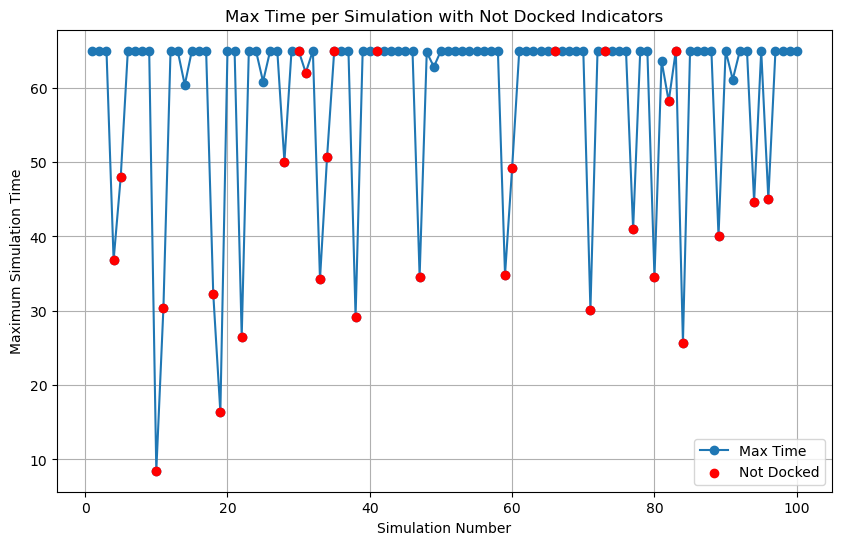

Success Rate: 0.71


In [40]:
# Extract maximum time from each simulation's data:
max_times = [time_data['t'][-1] for time_data in data]
sim_numbers = np.arange(1, len(data) + 1)

plt.figure(figsize=(10, 6))
plt.plot(sim_numbers, max_times, marker='o', linestyle='-', label="Max Time")

# Convert docked to a numpy array for easy indexing:
docked_arr = np.array(docked)
# Get indices where the simulation did NOT dock:
for docked in docked_arr:
    not_docked_indices = np.where(docked_arr == False)[0]

# Overlay red dots for simulations that did not dock:
plt.scatter(sim_numbers[not_docked_indices], np.array(max_times)[not_docked_indices], 
            color='red', label="Not Docked", zorder=10)

plt.xlabel("Simulation Number")
plt.ylabel("Maximum Simulation Time")
plt.title("Max Time per Simulation with Not Docked Indicators")
plt.legend()
plt.grid(True)
plt.show()

print(f"Success Rate: {success_rate:.2f}")